In [1]:
import sys
import os

# Check if the current platform is macOS
if sys.platform.startswith("darwin"):
    # For macOS with M1 chip, you might need to set CONDA_SUBDIR
    if os.uname().machine == "arm64":
        os.environ["CONDA_SUBDIR"] = "osx-64"
    
    # Install openmmforcefields
    os.system("conda install -q -y -c conda-forge openmmforcefields")


Channels:
 - conda-forge
 - defaults
 - https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/free
 - https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
 - pytorch
Platform: osx-64
Solving environment: ...working... done

# All requested packages already installed.


In [2]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/AI-drug-design/list/06_extension_lab/03_md/data


In [3]:
import copy
from pathlib import Path

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [4]:
pdbid = "3W32"
ligand_name = "W32"
pdb_path = DATA / f"{pdbid}.pdb"
pdb_url = f"https://files.rcsb.org/download/{pdbid}.pdb"

In [5]:
r = requests.get(pdb_url)
r.raise_for_status()
with open(pdb_path, "wb") as f:
    f.write(r.content)

制备蛋白质配体复合物
 蛋白质制备
成功模拟的关键是要有一个正确完整的系统。从蛋白质数据库（Protein Data Bank）中获取的晶体结构经常会遗漏原子（主要是氢原子），并且可能包含非标准残基。在本讲座中，我们将使用 Python 软件包 PDBFixer 来准备蛋白质结构。不过，PDBFixer 不能很好地处理共晶体配体，因此将单独制备。

In [6]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    使用pdbfixer从PDB文件中制备蛋白质。杂原子如配体是
    去除不符合标准的残留物替换。对已有的残基添加缺失原子。
    缺省残差默认忽略，但可以包含在内。
    参数
    - - - - - - - -
    pdb _ file：pathlib . Path或str
    包含系统的PDB文件进行模拟。
    忽略_缺失_残基：bool，可选
    如果缺失的残基应该被忽略或者构建。
    忽略_ terminal _ missing _ residue：bool，可选
    如果在链的开始和结束处缺失残基，则应该被忽略或建立。
    Ph：漂浮，可选
    PH值用于判断残基的质子化状态
    
    返回
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
          准备好的蛋白质系统
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # 共晶配体对PDBFixer来说是未知的
    fixer.findMissingResidues()  # 识别缺失残基，为识别缺失原子所需

    # 如果应忽略缺失的末端残基，则将其从字典中删除
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]

    # 如果所有缺失的残基都被忽略，则清空字典
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [7]:
# prepare protein and build only missing non-terminal residues
prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)

制备配体
准备好蛋白质后，我们将注意力转向配体。同样，我们需要添加氢，但也需要确保键序分配正确，因为一些 PDB 条目可能包含错误。我们使用 Python 软件包 RDKit，这是一个开源的化学信息学库。我们将通过 SMILES 字符串向 RDKit 提供正确的质子化状态和键序。每种共晶体配体的非带电异构体 SMILES 字符串可在其各自的 PDB 条目中找到。PDB 条目 3w32 的配体名称为 w32。如果配体可能以其带电形式或特定同分异构体形式结合，则需要将这些特征纳入 SMILES 字符串。

In [8]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    通过添加氢和指定键序，从 PDB 文件中制备配体。描述
    配体制备前后的二维图像，以便检查
    结果。非常感谢 @j-wags 的建议。
    参数
    ----------
    pdb_file: pathlib.PosixPath
    包含相关配体的 PDB 文件。
    resname: str
    配体的三个字符残基名称。
    smiles : str
    配体的 SMILES 字符串，用于说明正确的质子化和键序。
    depict：bool，可选
    显示配体的二维图像
    返回
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        制备配体。
    """
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand

同分异构体 SMILES 字符串调用该函数，将返回正确制备的配体。打印出原始配体和制备配体的二维图像，以供检查。

[03:09:23] WARNING: More than one matching pattern found - picking one



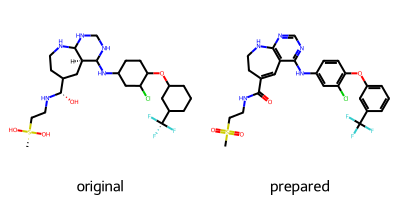

In [9]:
smiles = "CS(=O)(=O)CCNC(=O)C1=Cc2c(ncnc2Nc3ccc(c(c3)Cl)Oc4cccc(c4)C(F)(F)F)NCC1"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)

合并蛋白质和配体
下一步，我们要使用 Python 软件包 MDTraj 合并制备的蛋白质和配体结构。MDTraj 可以处理准备好的蛋白质，它目前是一个 PDBFixer 分子，这种格式的拓扑结构和原子位置与 OpenMM Modeller 的拓扑结构和位置相似，通常可以互换。但对于配体，我们需要进行多次转换，因为它目前是 RDKit 分子。

In [10]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    Inspired by @hannahbrucemcdonald and @glass-w.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [11]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

现在，蛋白质和配体都是类似 OpenMM 的格式，可以与 MDTraj 合并。

In [12]:
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: openmm.app.topology.Topology
        The merged topology.
    complex_positions: openmm.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [13]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)

/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/openmm/unit/quantity.py:753: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [14]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 5428 atoms.


MD 模拟设置
现在，我们可以使用准备好的复合物来设置 MD 模拟。

 力场
常见的力场（如 AMBER）有氨基酸、核酸、水和离子的参数，通常会根据您的目的提供多种选择。我们使用 amber14-all.xml 力场文件，该文件随 OpenMM 一起提供，包含蛋白质、DNA、RNA 和脂质的参数。对于溶解，我们使用标准的三基点水模型 TIP3P。

不过，配体的参数并不包括在内。要生成这些参数，我们可以使用通用安博力场（GAFF），它是在 Python 软件包 OpenMM Forcefields 中实现的。下面的函数生成了一个包含标准安博参数的力场对象，如果需要，还包括小分子的参数。

In [15]:
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmm import app
from openff.toolkit.topology import Molecule

def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        smirnoff = SMIRNOFFTemplateGenerator(
            molecules=[Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)],
            forcefield="openff-2.0.0.offxml"
        )
        forcefield.registerTemplateGenerator(smirnoff.generator)

    return forcefield


In [16]:
forcefield = generate_forcefield(rdkit_ligand)

系统
有了配置好的力场，我们现在就可以使用 OpenMM Modeller 类来创建 MD 环境，这是一个包含复合物并充满溶剂的模拟盒。标准溶剂是含有一定量离子的水。模拟盒的大小可以通过多种方式确定。我们使用填充来定义，这样就得到了一个立方体盒子，其尺寸取决于复合物的最大尺寸。

In [17]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

有了求解系统和力场，我们就可以创建 OpenMM 系统并进行仿真了。除了系统之外，模拟还需要一个积分器。OpenMM 积分器定义了通过积分运动方程模拟系统的方法。所选的朗温积分器使用朗温方程。

In [18]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

执行 MD 模拟
一切准备就绪后，我们就可以进行模拟了。我们需要设置起始位置，并将系统的能量最小化，以获得低能量的起始配置，这对于降低因严重原子冲突而导致模拟失败的几率非常重要。我们将保存能量最小化的系统。

In [19]:
simulation.minimizeEnergy()
with open(DATA / "topology.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
        file=pdb_file,
        keepIds=True,
    )

完成最小化后，我们就可以进行 MD 仿真了。在本讲座中，我们将做一个简短的仿真以作说明。用于研究目的的模拟时间跨度为几纳秒，甚至达到微秒。我们将只模拟 100 ps 的分子动力学，相当于 50k 步，每步 2 fs。我们每 10 ps（5000 步）保存一次分子 "快照"，总共 10 帧。结果保存在一个 .xtc 文件中，该文件包含所有原子在给定时间点的坐标。它与之前写入的能量最小化系统的 PDB 文件一起，为我们提供了稍后分析所需的所有信息。



In [20]:
steps = 50000  # corresponds to 100 ps
write_interval = 5000  # write every 10 ps
log_interval = 2500  # log progress to stdout every 5 ps

In [24]:
simulation.reporters.append(
    md.reporters.XTCReporter(file=str(DATA / "trajectory.xtc"), reportInterval=write_interval)
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

In [25]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(steps)  # perform the simulation

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
105.0%	52500	-963357.2224086337	299.9255524696846	0	--
110.0%	55000	-964113.9372523837	299.6586360620325	4.86	23:57:03
115.0%	57500	-964312.3122523837	299.9560348302563	4.87	23:55:34
120.0%	60000	-965307.4020961337	300.729221553349	4.87	23:54:06
125.0%	62500	-966199.3981898837	300.0890411102118	4.87	23:52:37
130.0%	65000	-964433.4997523837	300.37705695451837	4.87	23:51:09
135.0%	67500	-964478.0427211337	301.6519413917788	4.87	23:49:40
140.0%	70000	-964781.3435023837	298.0652014045315	4.87	23:48:12
145.0%	72500	-964332.5114711337	299.2705367761402	4.88	23:46:43
150.0%	75000	-965422.4528773837	299.73752931920353	4.88	23:45:15
155.0%	77500	-963212.0310023837	301.76555804253667	4.88	23:43:46
160.0%	80000	-965164.7614711337	299.1621833967417	4.88	23:42:18
165.0%	82500	-965434.0270961337	299.190619756499	4.88	23:40:49
170.0%	85000	-966322.4763148837	301.6244875796308	4.88	23:39:21
175.0%	8

In [26]:
# Check the trajectory exists and is not empty
(DATA / "trajectory.xtc").stat().st_size > 0


True

TypeError: saveState() got an unexpected keyword argument 'enforcePeriodicBox'

系统中所有粒子的速度都是从给定温度下的分布中随机选择的。我们选择了 300 开尔文，比室温高出几度。随机种子是生成的，但也可以明确给出以重现结果。

然后按照之前定义的步骤进行模拟